# Installing the NAG library and running this notebook

This notebook depends on the NAG library for Python to run. Please read the instructions in the [Readme.md](https://github.com/numericalalgorithmsgroup/NAGPythonExamples/blob/master/local_optimization/Readme.md#install) file to download, install and obtain a licence for the library.

Instruction on how to run the notebook can be found [here](https://github.com/numericalalgorithmsgroup/NAGPythonExamples/blob/master/local_optimization/Readme.md#jupyter).

# Orbital Data Fitting

Example of a nonlinear least-square orbital data fitting. Given a set of orbital data points the task is to estimate an optimal orbit path that minimizes the error between the path and the fixed data points.

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.patches as pch
from naginterfaces.base import utils
from naginterfaces.library import opt

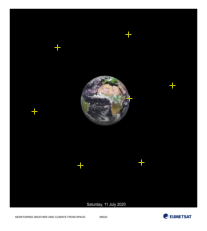

In [2]:
im = plt.imread("earth.png")
implot = plt.imshow(im)
tx = np.array([441.23, 484.31, 265.15, 98.25, 180.66, 439.13, 596.54])
ty = np.array([333.92, 563.46, 577.40, 379.23,  148.62, 100.28, 285.99])
cc = np.array([355.00, 347.00])
tr = (tx-cc[0])**2 + (ty-cc[1])**2
plt.plot(tx,ty,'y+')
plt.axis('off')
plt.savefig('dat_orbit.png', bbox_inches='tight', dpi=150)
plt.show()

Image credit: [Image of Earth](http://pics.eumetsat.int/viewer/index.html) was taken from [EUMETSAT, Copyright 2020](http://pics.eumetsat.int/viewer/index.html#help).


The previous image shows the orbit measurements to which an optimal orbit, `r`, must be estimated. 
The simple univariate problem to solve is:

![LaTeX equation: min f(x) = sum i=1 to nres of (tr[i]^2 - r^2)^2](ltx_optprb.png)

Here `tr[i]` contains the squared norm for the measurement point `i`, given by the coordinate pair `(tx[i], ty[i])`. Note that the coordinates for the center of the planet are provided by the vector `cc`.

In [3]:
# problem data
# number of observations
nres = len(tx)
# observations
# Define the data structure to be passed to the callback functions
data = {'tr': tr}
# number of parameter to fit
nvar = 1

In [4]:
# Define the least-square function and add first derivatives.
def lsqfun(x, nres, inform, data):
    """
    Objective function call back passed to the least squares solver.
    Return the difference between the current estimated radius squared, r^2=x^2 and 
    the squared norm of the data point stored in tr[i] for i = 1 to nres:
    rx[i] = r^2 - tr[i], i = 1, ..., nres.
    """
    rx = x**2 - data['tr']
    return rx, inform

def lsqgrd(x, nres, rdx, inform, data):
    """
    Computes the Jacobian of the least square residuals.
    Simply return rdx[i] = 2r, i = 1, ..., nres.
    """
    rdx[:] = 2.0*np.ones(nres)*x[:]
    return inform

In [5]:
# Initialize the model handle
handle = opt.handle_init(nvar)

# Define a dense nonlinear least-squares objective function
opt.handle_set_nlnls(handle, nres)

In [6]:
# Restrict parameter space (0 <= x)
opt.handle_set_simplebounds(handle, np.zeros(nvar), 1000.0*np.ones(nvar))

In [7]:
# Set some optional parameters to control the output of the solver
for option in [
        'Print Options = NO',
        'Print Level = 1',
        'Print Solution = X',
        'Bxnl Iteration Limit = 100'
]:
    opt.handle_opt_set(handle, option)

# Use an explicit I/O manager for abbreviated iteration output:
iom = utils.FileObjManager(locus_in_output=False)

In [8]:
# Define initial guess (starting point) Away from zero which is problematic.
x = np.ones(nvar)

Call the solver

In [9]:
# Call the solver
slv = opt.handle_solve_bxnl(handle, lsqfun, lsqgrd, x, nres, data=data, io_manager=iom)

 E04GG, Nonlinear least squares method for bound-constrained problems
 Status: converged, an optimal solution was found
 Value of the objective             1.45373E+09
 Norm of projected gradient         2.23690E-01
 Norm of scaled projected gradient  4.14848E-06
 Norm of step                       3.75533E-06

 Primal variables:
   idx   Lower bound       Value       Upper bound
     1   0.00000E+00    2.38765E+02    1.00000E+03


In [10]:
# Optimal parameter values
rstar = slv.x
print('Optimal Orbit Height: %3.2f' % rstar)

Optimal Orbit Height: 238.76


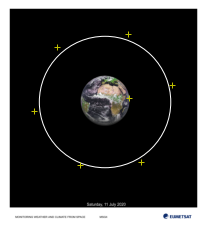

In [11]:
figure, axes = plt.figure(), plt.gca()
implot = plt.imshow(im)
orbit = plt.Circle(cc, radius=rstar, color='w', fill=False)
axes.add_patch(orbit)
plt.plot(tx, ty, 'y+')
plt.axis('off')
plt.savefig('est_orbit.png', bbox_inches='tight', dpi=150)
plt.show()

Suppose expert knowledge provides insight on the reliability of each measurement and that for this satellite configuration, operational orbit height should be around 250 +/-6 units. The previous image shows a fit where each measurement (data point) contributes the same amount and provides an optimal orbit height of 238.76 units. The fit is quite poor in the sense that it does not satisfy expert advice. Evidently data point 0 (yellow cross closest to Earth surface) is unreliable. Unreliability should be taken into account while doing the fitting. For this end, weights for each residuals are introduced (weights should be set to be proportional to the inverse of their variability). For this example, suppose we are provided with the accuracy for each of the data measurements. 

With this new information, the problem is solved again using weighted nonlinear least-squares. 

In [12]:
# Add weights for each residual
weights = np.array([0.10, 0.98, 1.01, 1.00, 0.92, 0.97, 1.02])
weights /= weights.sum()

# Define the reliability of the measurements (weights)
opt.handle_set_get_real(handle, 'rw', rarr=weights)

# Indicate to the solver that weights are to be used
for option in [
        'Bxnl Use weights = Yes',
]:
    opt.handle_opt_set(handle, option)

# Solve again
slv = opt.handle_solve_bxnl(handle, lsqfun, lsqgrd, x, nres, data=data, io_manager=iom) # monit=monit,

# Objective and solution
rstar = slv.x
print('Optimal Orbit Height: %3.2f' % rstar)

 E04GG, Nonlinear least squares method for bound-constrained problems
 Status: converged, an optimal solution was found
 Value of the objective             1.25035E+06
 Norm of projected gradient         6.26959E-03
 Norm of scaled projected gradient  3.96468E-06
 Norm of step                       8.72328E-03

 Primal variables:
   idx   Lower bound       Value       Upper bound
     1   0.00000E+00    2.54896E+02    1.00000E+03
Optimal Orbit Height: 254.90


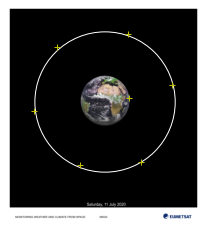

Optimal Orbit Height: 254.90 (should be between 244 and 256)


In [13]:
figure, axes = plt.figure(), plt.gca()
implot = plt.imshow(im)
orbit = plt.Circle(cc, radius=rstar, color='w', fill=False)
axes.add_patch(orbit)
plt.plot(tx, ty,'y+')
plt.axis('off')
plt.savefig('estw_orbit.png', bbox_inches='tight', dpi=150)
plt.show()
print('Optimal Orbit Height: %3.2f (should be between 244 and 256)' % rstar)

For this weighted model the orbital solution provided concurs with expert advice.